Full verstion with:
- train, test, validation.
- model saver
- tensorboard
- early stopping


In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)

C:\Users\kicjo\Desktop\my-anns\sinus\sinus_full


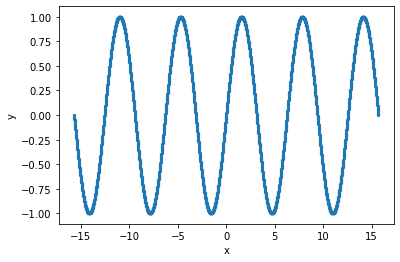

In [2]:
data_length = 2498
noise = np.random.normal(0.01, 0.3, data_length)
x = np.linspace(-5 * np.pi, 5 * np.pi, data_length)
y = np.sin(x)  # + noise
df = pd.DataFrame(data={'X': x, 'y': y})

plt.scatter(df["X"], df["y"], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)


In [3]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_o.reshape(-1, 1))
X_test = x_scaler.transform(X_test_o.reshape(-1, 1))
X_val = x_scaler.transform(X_val_o.reshape(-1, 1))

y_train = y_scaler.fit_transform(y_train_o.reshape(-1, 1))
y_test = y_scaler.transform(y_test_o.reshape(-1, 1))
y_val = y_scaler.transform(y_val_o.reshape(-1, 1))

n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]

In [4]:

with tf.name_scope("dnn"):
    with tf.name_scope("inputs"):
        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")

    hidden1 = tf.keras.layers.Dense(10, name="hidden1")(X)
    hidden2 = tf.keras.layers.Dense(150, name="hidden2", activation=tf.nn.leaky_relu)(hidden1)
    dropout = tf.keras.layers.Dropout(0.5)(hidden2)
    hidden3 = tf.keras.layers.Dense(50, name="hidden3")(dropout)    
    hidden4 = tf.keras.layers.Dense(150, name="hidden4", activation=tf.nn.leaky_relu)(hidden3)
    y_pred = tf.keras.layers.Dense(1, name="output")(hidden4)

with tf.name_scope('MSE'):
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    variable_summaries(mse)


with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer(0.01)
    training_op = optimiser.minimize(mse)

for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

W0816 20:47:51.373193 26228 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0816 20:47:51.458366 26228 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\sinus\sinus_full\utils.py:16: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0816 20:47:51.480371 26228 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\sinus\sinus_full\utils.py:22: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



In [5]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')
valid_writer = tf.summary.FileWriter(logdir + '/valid')
init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = os.path.join(dir_path, "sinus_tmp","sinus_full_model.ckpt")
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.path.join(dir_path, "model", "my_sinus_full_model")

In [6]:
best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 150

n_epochs = 1000
n_batches = 50


In [7]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            summary, _ = sess.run([merged, training_op],
                                  feed_dict={X: X_batch, y: y_batch})

        train_summary, _ = sess.run([merged, training_op],feed_dict={X: X_train, y: y_train})
        test_summary, _ =sess.run([merged, training_op],feed_dict={X: X_test, y: y_test})
        validation_summary, _ = sess.run([merged, training_op], feed_dict={X: X_val, y: y_val})

        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
        valid_writer.add_summary(validation_summary,epoch)

        loss_train = mse.eval(feed_dict={X: X_train, y: y_train})
        loss_val = mse.eval(feed_dict={X: X_val, y: y_val})
        print(epoch, "train loss:", loss_train, "valid loss:", loss_val)

        iteration_skip = 10
        if epoch % iteration_skip == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += iteration_skip
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break


train_writer.close()
test_writer.close()
valid_writer.close()

0 train loss: 0.98001117 valid loss: 0.89190537
1 train loss: 0.9839983 valid loss: 0.92470247
2 train loss: 0.95975065 valid loss: 0.8841166
3 train loss: 0.93665653 valid loss: 0.84872437
4 train loss: 0.96334445 valid loss: 0.87311447
5 train loss: 0.9330144 valid loss: 0.8648218
6 train loss: 0.9775277 valid loss: 0.89937544
7 train loss: 0.9900694 valid loss: 0.9059533
8 train loss: 0.9407714 valid loss: 0.86206645
9 train loss: 0.92870367 valid loss: 0.8437464
10 train loss: 0.93642026 valid loss: 0.85706294
11 train loss: 0.9052614 valid loss: 0.8059169
12 train loss: 0.8997963 valid loss: 0.80459577
13 train loss: 0.8805884 valid loss: 0.771035
14 train loss: 0.9592447 valid loss: 0.8648125
15 train loss: 0.8917313 valid loss: 0.79441255
16 train loss: 0.8735924 valid loss: 0.74741334
17 train loss: 0.98005235 valid loss: 0.89103127
18 train loss: 0.98224455 valid loss: 0.88997346
19 train loss: 0.88571095 valid loss: 0.78934723
20 train loss: 0.8807354 valid loss: 0.7580757
21

169 train loss: 0.018025592 valid loss: 0.016327238
170 train loss: 0.01618249 valid loss: 0.017838217
171 train loss: 0.020579023 valid loss: 0.018228346
172 train loss: 0.040155865 valid loss: 0.03680423
173 train loss: 0.17087598 valid loss: 0.17502412
174 train loss: 0.05995051 valid loss: 0.06369818
175 train loss: 0.015279715 valid loss: 0.015234683
176 train loss: 0.01302747 valid loss: 0.012533031
177 train loss: 0.013295808 valid loss: 0.013440329
178 train loss: 0.011040802 valid loss: 0.012037792
179 train loss: 0.021425962 valid loss: 0.02027964
180 train loss: 0.007121307 valid loss: 0.006337468
181 train loss: 0.009043145 valid loss: 0.009334948
182 train loss: 0.011262445 valid loss: 0.011652422
183 train loss: 0.009766244 valid loss: 0.010783388
184 train loss: 0.016875435 valid loss: 0.014411995
185 train loss: 0.016313208 valid loss: 0.01577762
186 train loss: 0.035253953 valid loss: 0.040321093
187 train loss: 0.014096734 valid loss: 0.016096245
188 train loss: 0.022

In [8]:
os.remove(checkpoint_epoch_path)

In [9]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse = mse.eval(feed_dict={X: X_test, y: y_test})
    predictions = y_pred.eval(feed_dict={X: X_test, y: y_test})
    
    
print(test_mse)

W0816 20:48:16.506497 26228 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.007377633


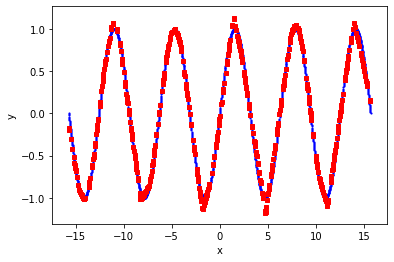

In [10]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

plt.scatter(df["X"], df["y"],s=5, color='b',marker='.')
plt.scatter(x_test_inverse, y_new_inverse,s=10, color='r',marker = ',')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

How will nn behave beyond seen range?

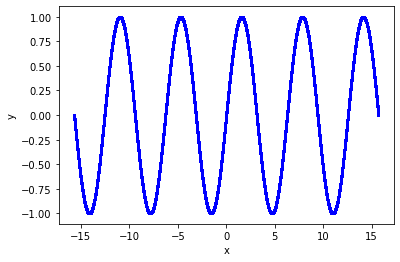

In [11]:
data_length = 10000
x_long = np.linspace(-5 * np.pi, 5 * np.pi, data_length)
y_long = np.sin(x_long) 

X_train_long = x_scaler.transform(x_long.reshape(-1, 1))
y_train_long = y_scaler.transform(y_long.reshape(-1, 1))

plt.scatter(x_long, y_long,s=5, color='b',marker = ',')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

In [12]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse_long = mse.eval(feed_dict={X: X_train_long, y: y_train_long})
    predictions_long = y_pred.eval(feed_dict={X: X_train_long, y: y_train_long})
    
    
print(test_mse_long)

0.0070373863


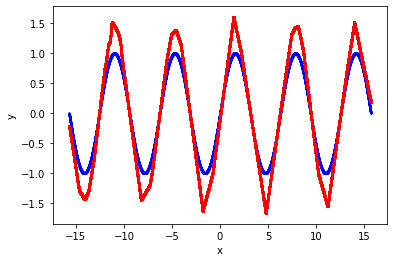

In [13]:
y_new_inverse_long = y_scaler.inverse_transform(predictions_long)
x_test_inverse_long = x_scaler.inverse_transform(X_train_long)

plt.scatter(x_long,y_long,s=5, color='b',marker='.')
plt.scatter(x_test_inverse_long, predictions_long,s=7, color='r',marker = ',')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

Easy to notice, some memory will be required 